# BBM 409: Machine Learning Laboratory
# Assignment 2

**Students:**
- Arda Ceylan: 2220356041
- Arya Zeynep Mete: 2210356104

**Objectives:**

In this project, our goal is to understand and apply the Decision Tree algorithm, specifically using the ID3 algorithm. We work with a Financial Risk Assessment dataset that includes information on 15,000 individuals, each described by 19 attributes—although some values are missing.

Our task is to predict each person’s financial risk. To do this, we handle the missing data with our own approach, then split the dataset randomly into training (70%), testing (15%), and validation (15%) sets. The project has two parts: first, we implement a decision tree using the ID3 algorithm; second, we apply pruning techniques to improve the model’s ability to generalize and perform better on unseen data.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Connection to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get files from local
# df = pd.read_csv("financial_risk_assessment.csv")

# Get files from drive
file_path = "/content/drive/My Drive/Colab_Notebooks/Assignment_2/financial_risk_assessment.csv"
df = pd.read_csv(file_path)

# Randomize the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# **Part 1 Implementing Decision Tree**

## **Observe Data**

In [ ]:
print(df.head()) # Displays the first 5 rows

   Age      Gender Education Level Marital Status   Income  Credit Score  \
0   51  Non-binary      Bachelor's         Single  50473.0         668.0   
1   66        Male      Bachelor's        Married  98342.0         788.0   
2   63        Male     High School         Single      NaN         768.0   
3   40      Female             PhD       Divorced  72513.0         714.0   
4   64        Male             PhD         Single      NaN         645.0   

   Loan Amount Loan Purpose Employment Status  Years at Current Job  \
0          NaN         Home     Self-employed                     2   
1      37371.0         Home          Employed                    13   
2      12775.0         Home          Employed                    10   
3       6759.0     Personal        Unemployed                    14   
4       9277.0     Personal     Self-employed                     6   

  Payment History  Debt-to-Income Ratio  Assets Value  Number of Dependents  \
0            Poor              0.2421

In [ ]:
# Categories
risk_counts = df['Risk Rating'].value_counts()

print(risk_counts)

Risk Rating
Low       9000
Medium    4500
High      1500
Name: count, dtype: int64


In [ ]:
print(f"Dataset Shape: {df.shape}")  # (rows, columns)

Dataset Shape: (15000, 20)


> Financial Risk Assessment Dataset contains information about 15,000 people, there are 19 attributes for each people, one extra column is class name

In [ ]:
# Check column names to see the feature names:
print(df.columns)

Index(['Age', 'Gender', 'Education Level', 'Marital Status', 'Income',
       'Credit Score', 'Loan Amount', 'Loan Purpose', 'Employment Status',
       'Years at Current Job', 'Payment History', 'Debt-to-Income Ratio',
       'Assets Value', 'Number of Dependents', 'City', 'State', 'Country',
       'Previous Defaults', 'Marital Status Change', 'Risk Rating'],
      dtype='object')


In [ ]:
# Statistical summary to get numerical insights:
print(df.describe())

                Age         Income  Credit Score   Loan Amount  \
count  15000.000000   12750.000000  12750.000000  12750.000000   
mean      43.452667   69933.398510    699.109098  27450.010902   
std       14.910732   29163.626207     57.229465  12949.940135   
min       18.000000   20005.000000    600.000000   5000.000000   
25%       31.000000   44281.500000    650.000000  16352.500000   
50%       43.000000   69773.000000    699.000000  27544.000000   
75%       56.000000   95922.750000    748.000000  38547.500000   
max       69.000000  119997.000000    799.000000  49998.000000   

       Years at Current Job  Debt-to-Income Ratio   Assets Value  \
count          15000.000000          15000.000000   12750.000000   
mean               9.476267              0.350438  159741.497176   
std                5.769707              0.143919   80298.115832   
min                0.000000              0.100004   20055.000000   
25%                4.000000              0.227386   90635.250000 

In [ ]:
# And let's see it's datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    15000 non-null  int64  
 1   Gender                 15000 non-null  object 
 2   Education Level        15000 non-null  object 
 3   Marital Status         15000 non-null  object 
 4   Income                 12750 non-null  float64
 5   Credit Score           12750 non-null  float64
 6   Loan Amount            12750 non-null  float64
 7   Loan Purpose           15000 non-null  object 
 8   Employment Status      15000 non-null  object 
 9   Years at Current Job   15000 non-null  int64  
 10  Payment History        15000 non-null  object 
 11  Debt-to-Income Ratio   15000 non-null  float64
 12  Assets Value           12750 non-null  float64
 13  Number of Dependents   12750 non-null  float64
 14  City                   15000 non-null  object 
 15  St

> Not all features are 15000, we can see there are some missing parts

In [ ]:
def analyze_columns(df):
    results = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            value_counts = df[col].value_counts(normalize=True) * 100
            results[col] = value_counts.round(2).to_dict()
        elif pd.api.types.is_numeric_dtype(df[col]):
            mean_value = df[col].mean()
            results[col] = f"Mean: {mean_value:.2f}"
        else:
            results[col] = "Data type"

    return results

analysis_result = analyze_columns(df)

for col, result in analysis_result.items():
    print(f"{col}: {result}")

Age: Mean: 43.45
Gender: {'Non-binary': 33.73, 'Female': 33.27, 'Male': 33.01}
Education Level: {"Bachelor's": 25.53, 'High School': 25.16, 'PhD': 25.07, "Master's": 24.25}
Marital Status: {'Widowed': 25.95, 'Divorced': 25.25, 'Single': 24.65, 'Married': 24.15}
Income: Mean: 69933.40
Credit Score: Mean: 699.11
Loan Amount: Mean: 27450.01
Loan Purpose: {'Personal': 25.14, 'Home': 25.11, 'Business': 24.92, 'Auto': 24.83}
Employment Status: {'Employed': 33.51, 'Self-employed': 33.27, 'Unemployed': 33.22}
Years at Current Job: Mean: 9.48
Payment History: {'Good': 25.48, 'Excellent': 25.26, 'Poor': 24.77, 'Fair': 24.49}
Debt-to-Income Ratio: Mean: 0.35
Assets Value: Mean: 159741.50
Number of Dependents: Mean: 2.03
City: {'East Michael': 0.13, 'Port Michael': 0.11, 'Lake Michael': 0.11, 'West Michael': 0.09, 'West David': 0.09, 'Lake James': 0.09, 'South Christopher': 0.08, 'North James': 0.08, 'North Michael': 0.08, 'South Jennifer': 0.07, 'Port Christopher': 0.07, 'Williamsmouth': 0.07, 'P

> In order to observe the distribution of the data set, we made an observation by taking percentages in string values ​​and averages in numerical values


## **Preprocessing Data**

In [ ]:
# Label Encoding
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    labels = df[column].unique()
    label_map = {label: idx for idx, label in enumerate(labels)}

    df[column] = df[column].map(label_map)

print(df.head())

   Age  Gender  Education Level  Marital Status   Income  Credit Score  \
0   51       0                0               0  50473.0         668.0   
1   66       1                0               1  98342.0         788.0   
2   63       1                1               0      NaN         768.0   
3   40       2                2               2  72513.0         714.0   
4   64       1                2               0      NaN         645.0   

   Loan Amount  Loan Purpose  Employment Status  Years at Current Job  \
0          NaN             0                  0                     2   
1      37371.0             0                  1                    13   
2      12775.0             0                  1                    10   
3       6759.0             1                  2                    14   
4       9277.0             1                  0                     6   

   Payment History  Debt-to-Income Ratio  Assets Value  Number of Dependents  \
0                0              0.24

In [ ]:
# Min-max scaling
for column in df.select_dtypes(include=['int64', 'float64']).columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

## **Handling Missing Data**

In [ ]:
# Checking for missing values using isnull()

def isMissing(df):
  missing_values = df.isnull().sum()
  print(missing_values)

isMissing(df)

Age                         0
Gender                      0
Education Level             0
Marital Status              0
Income                   2250
Credit Score             2250
Loan Amount              2250
Loan Purpose                0
Employment Status           0
Years at Current Job        0
Payment History             0
Debt-to-Income Ratio        0
Assets Value             2250
Number of Dependents     2250
City                        0
State                       0
Country                     0
Previous Defaults        2250
Marital Status Change       0
Risk Rating                 0
dtype: int64


> There are some missing values, we should handle them

> When working with missing data in Pandas, the fillna(), replace(), and interpolate() functions are commonly used to fill NaN values. These functions allow to replace missing values with a specific value or use interpolation techniques.

> It is more logical to fill in the gaps with appropriate mathematical methods rather than removing rows with missing data directly from the dataset, so we do not lose data.

In [ ]:
# All missing values are numerical, so we can replace them with numerical values
# The interpolate() function fills missing values using interpolation techniques, such as the linear method.
# But its estimates missing values ​​based on previous and subsequent values. It is especially useful for sequential, time-series, or continuous data. Our data is random so we shouldn't use it.
# We should use Median to fill missing values.
df = df.fillna(df.median())

isMissing(df)

Age                      0
Gender                   0
Education Level          0
Marital Status           0
Income                   0
Credit Score             0
Loan Amount              0
Loan Purpose             0
Employment Status        0
Years at Current Job     0
Payment History          0
Debt-to-Income Ratio     0
Assets Value             0
Number of Dependents     0
City                     0
State                    0
Country                  0
Previous Defaults        0
Marital Status Change    0
Risk Rating              0
dtype: int64


> Now we handle all the missing values in dataset

## **Feature Selection**

In [ ]:
# Define the threshold
threshold = 0.9 * (1 - 0.9)  # 0.09

# Calculate variance for each column
variances = df.var()

# Keep only columns with variance above the threshold
df = df.loc[:, variances > threshold]

print(df)

       Gender  Education Level  Marital Status  Loan Purpose  \
0         0.0         0.000000        0.000000      0.000000   
1         0.5         0.000000        0.333333      0.000000   
2         0.5         0.333333        0.000000      0.000000   
3         1.0         0.666667        0.666667      0.333333   
4         0.5         0.666667        0.000000      0.333333   
...       ...              ...             ...           ...   
14995     0.0         1.000000        0.666667      0.000000   
14996     0.5         0.666667        0.666667      1.000000   
14997     1.0         0.000000        0.000000      0.000000   
14998     0.0         0.666667        0.666667      0.000000   
14999     1.0         0.333333        1.000000      0.666667   

       Employment Status  Years at Current Job  Payment History  \
0                    0.0              0.105263         0.000000   
1                    0.5              0.684211         0.333333   
2                    0.5      

## **Split data into train, test, and validation set**

In [ ]:
x = df.drop(columns=['Risk Rating']).values
y = df['Risk Rating'].values
feature_names = df.drop(columns=['Risk Rating']).columns
print(feature_names)

Index(['Gender', 'Education Level', 'Marital Status', 'Loan Purpose',
       'Employment Status', 'Years at Current Job', 'Payment History',
       'Number of Dependents', 'Previous Defaults', 'Marital Status Change'],
      dtype='object')


In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

## **Train ID3 decision tree model with respect to features selected**

> By choosing the best characteristic at each node to partition the data depending on information gain, it recursively constructs a tree.

In [ ]:
class Node:
    def __init__(self, feature=None, value=None, results=None, true_branch=None, false_branch=None):
        self.feature = feature  # Feature to split on
        self.value = value      # Value of the feature to split on
        self.results = results  # Stores class labels if node is a leaf node
        self.true_branch = true_branch  # Branch for values that are True for the feature
        self.false_branch = false_branch  # Branch for values that are False for the feature


In [ ]:
def entropy(data):
    counts = np.bincount(data.astype(int) )
    probabilities = counts / len(data)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy


In [ ]:
def split_data(x, y, feature, value):
    true_indices = np.where(x[:, feature] <= value)[0]
    false_indices = np.where(x[:, feature] > value)[0]
    true_x, true_y = x[true_indices], y[true_indices]
    false_x, false_y = x[false_indices], y[false_indices]
    return true_x, true_y, false_x, false_y


In [ ]:
def build_tree(x, y, max_depth=None, current_depth=0):
    # If all samples belong to the same class, return a leaf node
    if len(set(y)) == 1:
        return Node(results=y[0])

    # If max_depth is reached, return a leaf node with the majority class
    if max_depth is not None and current_depth >= max_depth:
        majority_class = np.bincount(y.astype(int)).argmax()
        return Node(results=majority_class)

    best_gain = 0
    best_criteria = None
    best_sets = None
    n_features = x.shape[1]

    current_entropy = entropy(y)

    for feature in range(n_features):
        feature_values = set(x[:, feature])
        for value in feature_values:
            true_x, true_y, false_x, false_y = split_data(x, y, feature, value)

            # Skip if split doesn't meet minimum requirements
            if len(true_y) == 0 or len(false_y) == 0:
                continue

            true_entropy = entropy(true_y)
            false_entropy = entropy(false_y)
            p = len(true_y) / len(y)
            gain = current_entropy - p * true_entropy - (1 - p) * false_entropy

            if gain > best_gain:
                best_gain = gain
                best_criteria = (feature, value)
                best_sets = (true_x, true_y, false_x, false_y)

    if best_gain > 0:
        true_branch = build_tree(best_sets[0], best_sets[1], max_depth, current_depth + 1)
        false_branch = build_tree(best_sets[2], best_sets[3], max_depth, current_depth + 1)
        return Node(feature=best_criteria[0], value=best_criteria[1],
                   true_branch=true_branch, false_branch=false_branch)

    return Node(results=y[0])

In [ ]:
def predict(tree, sample):
    if tree.results is not None:
        return tree.results
    else:
        branch = tree.false_branch
        if sample[tree.feature] <= tree.value:
            branch = tree.true_branch
        return predict(branch, sample)


In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

# Building the tree
decision_tree = build_tree(x_train, y_train)

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    y_true = pd.Series(y_true, name="Actual")
    y_pred = pd.Series(y_pred, name="Predicted")

    conf_matrix = pd.crosstab(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                cmap='Blues', cbar=False, square=True,
                xticklabels=conf_matrix.columns,
                yticklabels=conf_matrix.index)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_scores(y_true, y_pred):
    # Calculate confusion matrix
    classes = sorted(list(set(y_true + y_pred)))
    confusion_matrix = {}
    for true_class in classes:
        confusion_matrix[true_class] = {}
        for pred_class in classes:
            confusion_matrix[true_class][pred_class] = 0

    for true, pred in zip(y_true, y_pred):
        confusion_matrix[true][pred] += 1

    # Calculate metrics for each class
    metrics = {}
    for cls in classes:
        true_positives = confusion_matrix[cls][cls]
        false_positives = sum(confusion_matrix[other][cls] for other in classes if other != cls)
        false_negatives = sum(confusion_matrix[cls][other] for other in classes if other != cls)
        true_negatives = sum(confusion_matrix[other][other_cls]
                            for other in classes if other != cls
                            for other_cls in classes if other_cls != cls)

        # Accuracy components (same for all classes)
        accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0

        # Precision
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

        # Recall
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[cls] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Calculate weighted averages
    class_counts = {cls: sum(confusion_matrix[cls].values()) for cls in classes}
    total_samples = sum(class_counts.values())

    weighted_precision = sum(metrics[cls]['precision'] * class_counts[cls] for cls in classes) / total_samples
    weighted_recall = sum(metrics[cls]['recall'] * class_counts[cls] for cls in classes) / total_samples
    weighted_f1 = sum(metrics[cls]['f1'] * class_counts[cls] for cls in classes) / total_samples

    # Overall accuracy (same as micro-averaged)
    correct = sum(confusion_matrix[cls][cls] for cls in classes)
    accuracy = correct / total_samples if total_samples > 0 else 0

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {weighted_precision:.2f}")
    print(f"Recall: {weighted_recall:.2f}")
    print(f"F1 Score: {weighted_f1:.2f}")

    plot_confusion_matrix(y_true, y_pred)

Accuracy: 0.46
Precision: 0.48
Recall: 0.46
F1 Score: 0.47


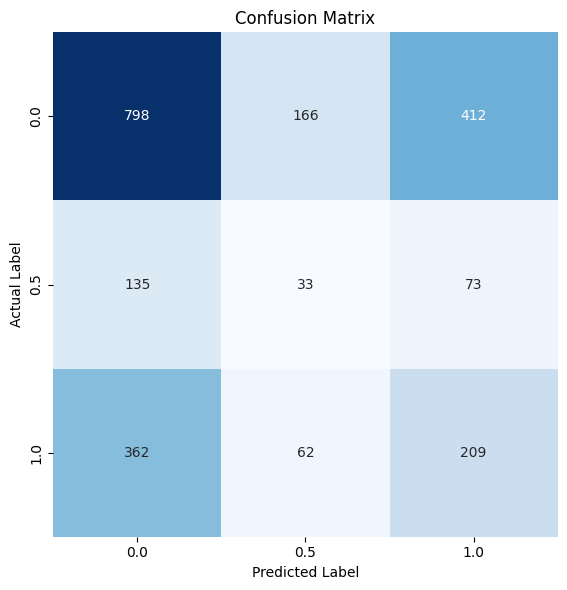

In [ ]:
y_pred_test = [predict(decision_tree, sample) for sample in x_test]
y_test = np.array(y_test)
y_pred_test = np.array(y_pred_test)
calculate_scores(y_test, y_pred_test)

> The accuracy is low, it could be underfitting or overfitting.

Accuracy: 0.87
Precision: 0.88
Recall: 0.87
F1 Score: 0.87


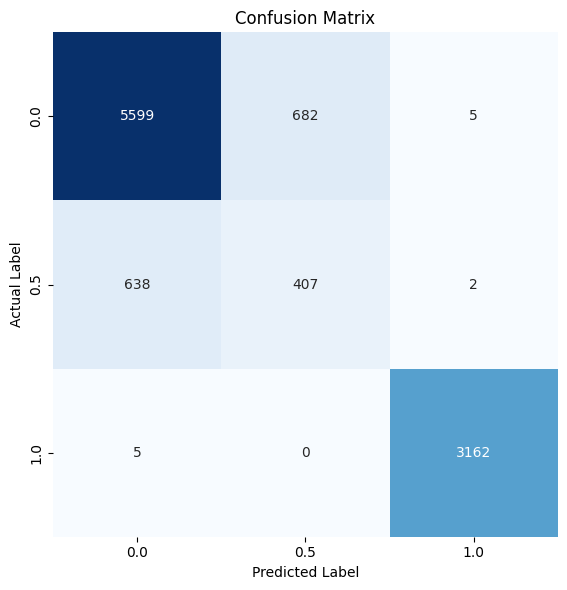

In [ ]:
y_pred_train = [predict(decision_tree, sample) for sample in x_train]
y_train = np.array(y_train)
y_pred_train = np.array(y_pred_train)
calculate_scores(y_train, y_pred_train)

> Training accuracy is high but test accuracy is low, this show that the model is **overfit** the data.

Accuracy: 0.61
Precision: 0.37
Recall: 0.61
F1 Score: 0.46


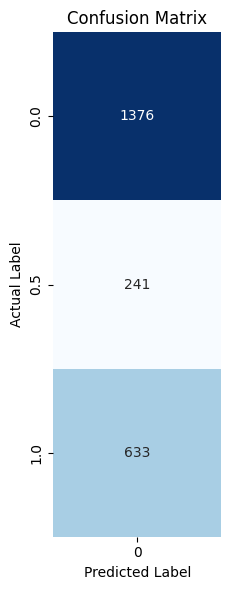

In [ ]:
# try with different parameters to increase accuracy

# Building the tree with max depth = 3
decision_tree_3 = build_tree(x_train, y_train, max_depth=3)

y_pred_test = [predict(decision_tree_3, sample) for sample in x_test]
y_test = np.array(y_test)
y_pred_test = np.array(y_pred_test)
calculate_scores(y_test, y_pred_test)

Accuracy: 0.60
Precision: 0.43
Recall: 0.60
F1 Score: 0.47


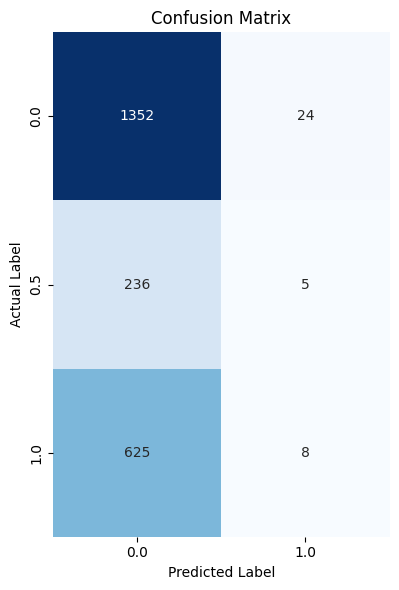

In [ ]:
# try with different parameters

# Building the tree with max depth = 6
decision_tree_6 = build_tree(x_train, y_train, max_depth=6)

y_pred_test = [predict(decision_tree_6, sample) for sample in x_test]
y_test = np.array(y_test)
y_pred_test = np.array(y_pred_test)
calculate_scores(y_test, y_pred_test)

Accuracy: 0.60
Precision: 0.44
Recall: 0.60
F1 Score: 0.47


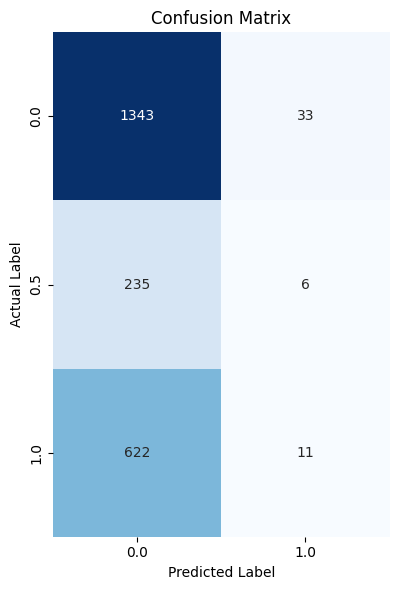

In [ ]:
# try with different parameters

# Building the tree with max depth = 7
decision_tree_7 = build_tree(x_train, y_train, max_depth=7)

y_pred_test = [predict(decision_tree_7, sample) for sample in x_test]
y_test = np.array(y_test)
y_pred_test = np.array(y_pred_test)
calculate_scores(y_test, y_pred_test)

Accuracy: 0.59
Precision: 0.44
Recall: 0.59
F1 Score: 0.47


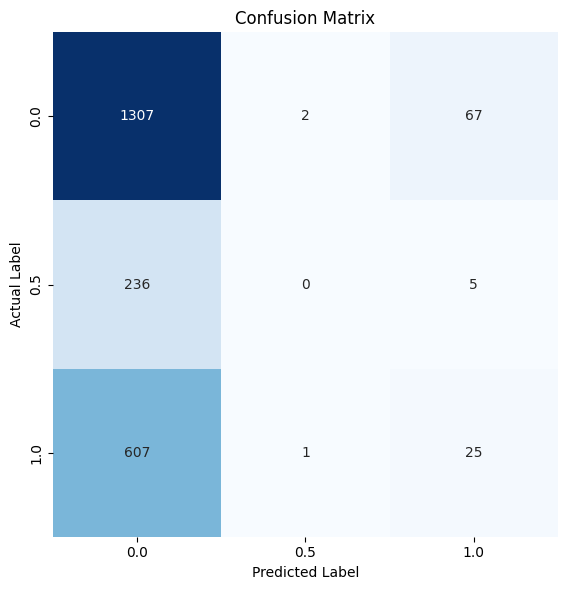

In [ ]:
# try with different parameters

# Building the tree with max depth = 8
decision_tree_8 = build_tree(x_train, y_train, max_depth=8)

y_pred_test = [predict(decision_tree_8, sample) for sample in x_test]
y_test = np.array(y_test)
y_pred_test = np.array(y_pred_test)
calculate_scores(y_test, y_pred_test)

## **For Best Pre Prunning Tree**

> best parameter for max depth is 7

Test Set: 
Accuracy: 0.60
Precision: 0.44
Recall: 0.60
F1 Score: 0.47


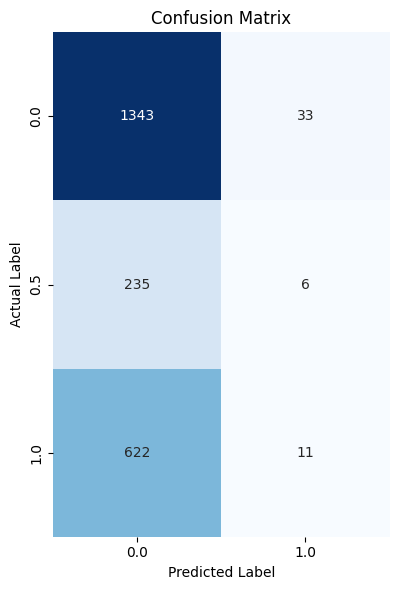


Train Set: 
Accuracy: 0.61
Precision: 0.67
Recall: 0.61
F1 Score: 0.47


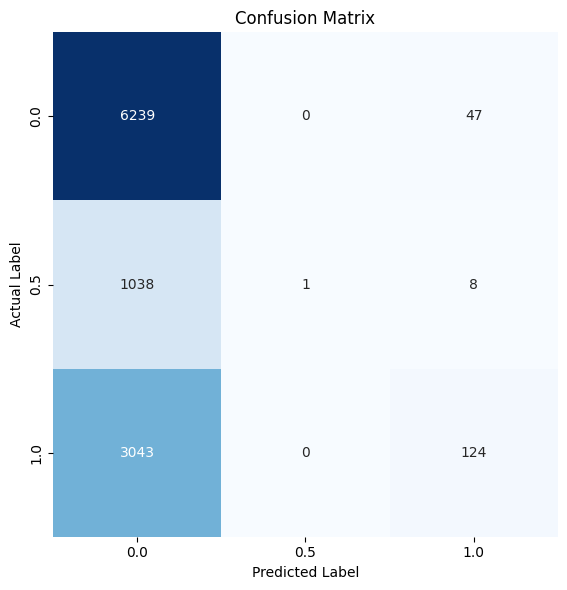


Validation Set: 
Accuracy: 0.59
Precision: 0.53
Recall: 0.59
F1 Score: 0.45


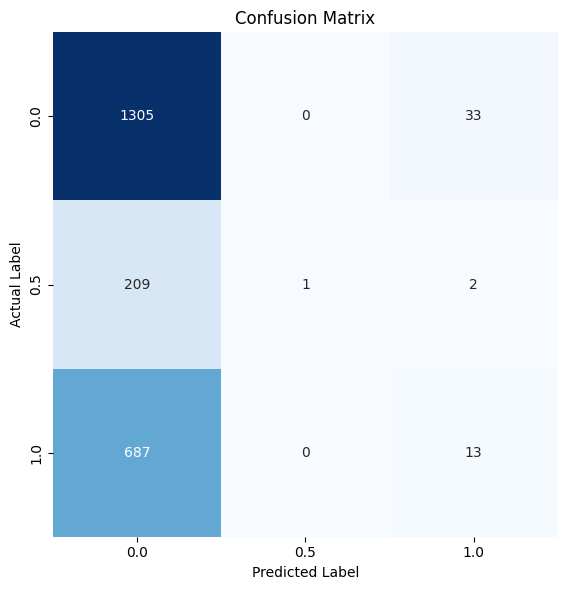

In [ ]:
# try with different parameters

# Building the tree with max depth = 7
decision_tree_7 = build_tree(x_train, y_train, max_depth=7)

print("Test Set: ")
y_pred_test = [predict(decision_tree_7, sample) for sample in x_test]
y_test = np.array(y_test)
y_pred_test = np.array(y_pred_test)
calculate_scores(y_test, y_pred_test)

print("\nTrain Set: ")
y_pred_train = [predict(decision_tree_7, sample) for sample in x_train]
y_train = np.array(y_train)
y_pred_train = np.array(y_pred_train)
calculate_scores(y_train, y_pred_train)

print("\nValidation Set: ")
y_pred_val = [predict(decision_tree_7, sample) for sample in x_val]
y_val = np.array(y_val)
y_pred_val = np.array(y_pred_val)
calculate_scores(y_val, y_pred_val)

> adding "max depth" is a constraint, so the train accuracy is decresing

## **Rules for our best decision tree model variation and all root-to-leaf paths in left-to-right order**

In [ ]:
def get_decision_paths(tree, feature_names=None, current_path=None, all_paths=None):
    if all_paths is None:
        all_paths = []
    if current_path is None:
        current_path = []

    # Leaf node - complete the path
    if tree.results is not None:
        path_str = " AND ".join(current_path) if current_path else "ALWAYS"
        all_paths.append(f"IF {path_str} THEN class = {tree.results}")
        return all_paths

    # Process left (true) branch
    feature = tree.feature
    feature_desc = f"feature_{feature}" if feature_names is None else feature_names[feature]
    left_condition = f"{feature_desc} <= {tree.value}"
    get_decision_paths(tree.true_branch, feature_names, current_path + [left_condition], all_paths)

    # Process right (false) branch
    right_condition = f"{feature_desc} > {tree.value}"
    get_decision_paths(tree.false_branch, feature_names, current_path + [right_condition], all_paths)

    return all_paths

In [ ]:
# Get rules as a list and all paths
print("All Decision Paths and Rules:")
paths = get_decision_paths(decision_tree_7, feature_names=feature_names)
for i, path in enumerate(paths, 1):
  print(f"Path {i}: {path}")

All Decision Paths and Rules:
Path 1: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job <= 0.0 AND Employment Status <= 0.0 AND Education Level <= 0.0 THEN class = 0.5
Path 2: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job <= 0.0 AND Employment Status <= 0.0 AND Education Level > 0.0 THEN class = 1.0
Path 3: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job <= 0.0 AND Employment Status > 0.0 THEN class = 0.0
Path 4: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job > 0.0 AND Payment History <= 0.0 AND Marital Status Change <= 0.5 THEN class = 0.0
Path 5: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job > 0.0 AND Paymen

## **Few misclassified people and possibilities for why**

In [ ]:
def find_misclassified_samples(tree, x, y, feature_names=None):
    misclassified = []

    for i in range(len(x)):
        sample = x[i]
        true_label = y[i]
        pred_label = predict(tree, sample)

        if pred_label != true_label:
            # Get the decision path for this sample
            path = trace_decision_path(tree, sample, feature_names)

            misclassified.append({
                'sample_index': i,
                'features': sample,
                'true_label': true_label,
                'predicted_label': pred_label,
                'decision_path': path
            })

    return misclassified

def trace_decision_path(tree, sample, feature_names=None, path=None):
    if path is None:
        path = []

    if tree.results is not None:
        path.append(f"→ Final prediction: {tree.results}")
        return path

    feature = tree.feature
    value = sample[feature]
    feature_desc = f"feature_{feature}" if feature_names is None else feature_names[feature]

    if value <= tree.value:
        path.append(f"{feature_desc} <= {tree.value}")
        return trace_decision_path(tree.true_branch, sample, feature_names, path)
    else:
        path.append(f"{feature_desc} > {tree.value}")
        return trace_decision_path(tree.false_branch, sample, feature_names, path)

In [ ]:
misclassified = find_misclassified_samples(decision_tree_7, x_train, y_train,
                                         feature_names=feature_names)

# Print analysis of first few misclassified samples
for i, case in enumerate(misclassified[:5]):  # Examine first 5 misclassified
    print(f"\nMisclassified Sample #{i+1}:")
    print(f"- Index: {case['sample_index']}")
    print(f"- True Label: {case['true_label']}")
    print(f"- Predicted Label: {case['predicted_label']}")
    print("Decision Path:")
    for step in case['decision_path']:
        print(f"  {step}")

    # Adding our observations about why this might be hard to classify
    print("\nPotential reasons for misclassification:")
    # Example analysis - customize based on our actual features
    if "age" in case['decision_path'][0] and "income" in case['decision_path'][1]:
        print("  - Complex interaction between age and income thresholds")
    if len(case['decision_path']) > 6:  # Deep decision path
        print("  - Requires many decision steps (complex case)")
    if case['true_label'] == 1 and case['predicted_label'] == 0:
        print("  - False negative: model is being too conservative")
    elif case['true_label'] == 0 and case['predicted_label'] == 1:
        print("  - False positive: model is being too aggressive")


Misclassified Sample #1:
- Index: 3
- True Label: 1.0
- Predicted Label: 0
Decision Path:
  Previous Defaults > 0.0
  Years at Current Job <= 0.7368421052631579
  Previous Defaults <= 0.5
  Previous Defaults > 0.25
  Gender <= 0.5
  Number of Dependents <= 0.25
  Loan Purpose > 0.0
  → Final prediction: 0

Potential reasons for misclassification:
  - Requires many decision steps (complex case)
  - False negative: model is being too conservative

Misclassified Sample #2:
- Index: 5
- True Label: 0.5
- Predicted Label: 0
Decision Path:
  Previous Defaults > 0.0
  Years at Current Job <= 0.7368421052631579
  Previous Defaults <= 0.5
  Previous Defaults > 0.25
  Gender > 0.5
  Employment Status <= 0.0
  Years at Current Job > 0.21052631578947367
  → Final prediction: 0

Potential reasons for misclassification:
  - Requires many decision steps (complex case)

Misclassified Sample #3:
- Index: 6
- True Label: 1.0
- Predicted Label: 0
Decision Path:
  Previous Defaults > 0.0
  Years at Curre

# **Part 2 Pruning Decision Tree**

- Our tree is inherently memorized the training data instead of learning from it and that results overfitting.

- Over-fitting happens when a model fits on training data so well and it fails to generalize, it also learns noises on top of the signal.

- Decision trees are useful model but it can easily get overfit. Pruning is one of the mainly used technique to avoid/overcome overfitting.

- We can prun the leaves that gives less, keeping the leaves
 that gives more.

- If effect of a leaf is less, it's probably memorizing which results with overfitting.

Accuracy: 0.59
Precision: 0.53
Recall: 0.59
F1 Score: 0.45


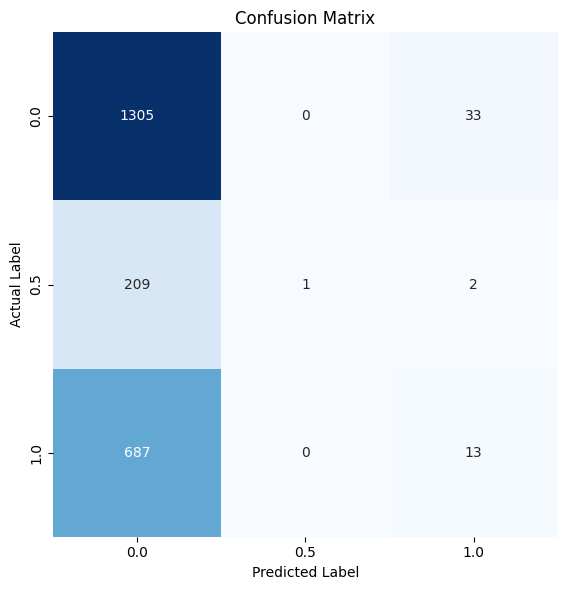

In [ ]:
# Last Accuracy: accuracy of our decision tree model on the validation set
# before the pruning process

# our best modal with max depth = 7 on val set
#last_accuracy_tree = build_tree(x_val, y_val, max_depth=7)
last_accuracy_tree = decision_tree_7

y_pred_val = [predict(last_accuracy_tree, sample) for sample in x_val]
y_val = np.array(y_val)
y_pred_val = np.array(y_pred_val)
calculate_scores(y_val, y_pred_val)

> Note: In some sources they refer a term that ***pre pruning*** which is nothing but stoping the growth of decision tree on an early stage. For that they can limit the growth of trees by setting constrains like max_depth which we have already done in "Part 1" and also here.

## **Post pruning**

In [ ]:
def calculate_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def find_twigs(node, twigs=None, parent=None, is_true_branch=None):
    # Catalog all twigs in the tree (nodes with both branches as leaves)
    if twigs is None:
        twigs = []

    if node is None:
        return twigs

    # Check if both branches are leaves
    if (node.true_branch is not None and node.false_branch is not None and
        node.true_branch.results is not None and node.false_branch.results is not None):
        twigs.append((node, parent, is_true_branch))

    # Recursively check children
    find_twigs(node.true_branch, twigs, node, True)
    find_twigs(node.false_branch, twigs, node, False)

    return twigs

def calculate_information_gain(x, y, feature, value):
    true_x, true_y, false_x, false_y = split_data(x, y, feature, value)

    if len(true_y) == 0 or len(false_y) == 0:
        return 0

    current_entropy = entropy(y)
    true_entropy = entropy(true_y)
    false_entropy = entropy(false_y)
    p = len(true_y) / len(y)
    gain = current_entropy - p * true_entropy - (1 - p) * false_entropy
    return gain

def predict(tree, sample):
    if tree.results is not None:
        return tree.results
    else:
        # Check if feature and value exist (might be None in leaf nodes)
        if tree.feature is not None and tree.value is not None:
            branch = tree.false_branch
            if sample[tree.feature] <= tree.value:
                branch = tree.true_branch
            return predict(branch, sample)
        else:
            # This should theoretically never happen if tree is properly built
            return tree.results if tree.results is not None else 0.0  # default value

def prune_tree(tree, x_val, y_val, x_train, y_train):
    last_accuracy = calculate_accuracy(y_val, [predict(tree, sample) for sample in x_val])
    print(f"Initial validation accuracy: {last_accuracy:.4f}")

    while True:
        # Step 1: Catalog all twigs (nodes with both children as leaves)
        twigs = find_twigs(tree)
        if not twigs:
            print("No more twigs to prune")
            break

        # Step 2: Find the twig with least information gain ≤ 0.0001
        min_gain = float('inf')
        selected_twig = None

        # Store candidate twigs with gain ≤ 0.0001
        candidate_twigs = []

        for twig, parent, is_true in twigs:
            # Skip if feature or value is None
            if twig.feature is None or twig.value is None:
                continue

            try:
                gain = calculate_information_gain(x_train, y_train, twig.feature, twig.value)
                if gain <= 0.0001:  # Only consider twigs with very small gain
                    candidate_twigs.append((gain, twig, parent, is_true))
                    if gain < min_gain:
                        min_gain = gain
            except:
                continue

        if not candidate_twigs:
            print("No twigs found with gain ≤ 0.0001")
            break

        # Select the twig with smallest gain among candidates
        selected_gain, selected_twig, selected_parent, is_true_branch = min(candidate_twigs, key=lambda x: x[0])
        print(f"Selected twig with gain: {selected_gain:.6f}")

        # Step 3 & 4: Convert to leaf node
        # Store original state
        original_state = {
            'true_branch': selected_twig.true_branch,
            'false_branch': selected_twig.false_branch,
            'feature': selected_twig.feature,
            'value': selected_twig.value,
            'results': selected_twig.results
        }

        # Get results from both branches
        true_results = selected_twig.true_branch.results
        false_results = selected_twig.false_branch.results

        # Combine results
        combined = []
        if isinstance(true_results, np.ndarray):
            combined.extend(true_results)
        else:
            combined.append(true_results)
        if isinstance(false_results, np.ndarray):
            combined.extend(false_results)
        else:
            combined.append(false_results)

        # Find majority class
        combined = np.array(combined)
        unique, counts = np.unique(combined, return_counts=True)
        majority_class = unique[np.argmax(counts)]

        # Convert to leaf node
        selected_twig.results = majority_class
        selected_twig.true_branch = None
        selected_twig.false_branch = None

        # Step 5: Measure current accuracy
        current_accuracy = calculate_accuracy(y_val, [predict(tree, sample) for sample in x_val])
        print(f"New accuracy after pruning: {current_accuracy:.4f}")

        # Step 6: Check accuracy condition
        if current_accuracy >= last_accuracy:
            last_accuracy = current_accuracy
            print("Pruning improved or maintained accuracy, continuing...")
        else:
            # Revert changes
            print("Pruning reduced accuracy, reverting changes and terminating")
            selected_twig.true_branch = original_state['true_branch']
            selected_twig.false_branch = original_state['false_branch']
            selected_twig.results = original_state['results']
            break

    return tree

# Prune the tree that was built on validation set (last_accuracy_tree)
print("Pruning process starting...")
#init_accur = calculate_accuracy(y_val, [predict(last_accuracy_tree, sample) for sample in x_val])
pruned_tree = prune_tree(last_accuracy_tree, x_val, y_val, x_train, y_train)

Pruning process starting...
Initial validation accuracy: 0.5862
Selected twig with gain: 0.000000
New accuracy after pruning: 0.5862
Pruning improved or maintained accuracy, continuing...
Selected twig with gain: 0.000000
New accuracy after pruning: 0.5862
Pruning improved or maintained accuracy, continuing...
Selected twig with gain: 0.000000
New accuracy after pruning: 0.5862
Pruning improved or maintained accuracy, continuing...
Selected twig with gain: 0.000000
New accuracy after pruning: 0.5867
Pruning improved or maintained accuracy, continuing...
Selected twig with gain: 0.000000
New accuracy after pruning: 0.5867
Pruning improved or maintained accuracy, continuing...
Selected twig with gain: 0.000000
New accuracy after pruning: 0.5867
Pruning improved or maintained accuracy, continuing...
Selected twig with gain: 0.000000
New accuracy after pruning: 0.5867
Pruning improved or maintained accuracy, continuing...
Selected twig with gain: 0.000001
New accuracy after pruning: 0.5867

## **For Best Post Prunning Tree**

Test Set: 
Accuracy: 0.61
Precision: 0.45
Recall: 0.61
F1 Score: 0.47


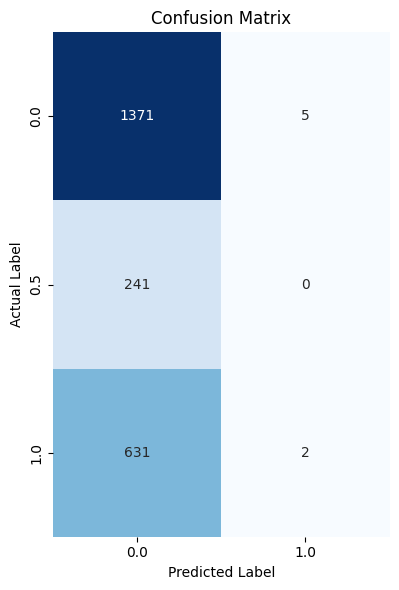


Train Set: 
Accuracy: 0.60
Precision: 0.57
Recall: 0.60
F1 Score: 0.45


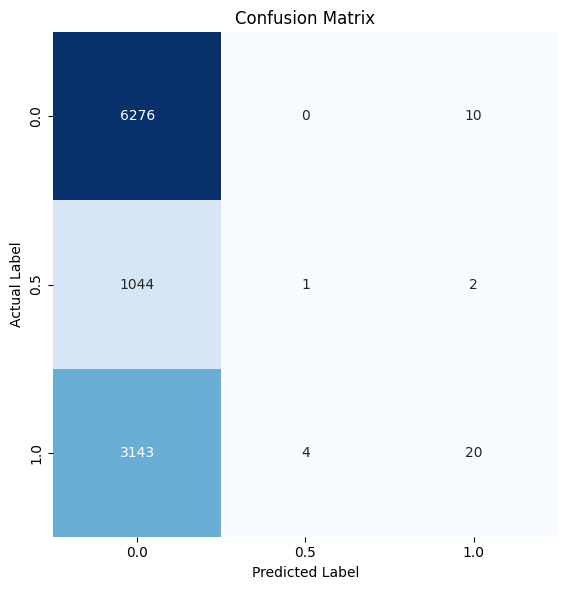


Validation Set: 
Accuracy: 0.59
Precision: 0.50
Recall: 0.59
F1 Score: 0.45


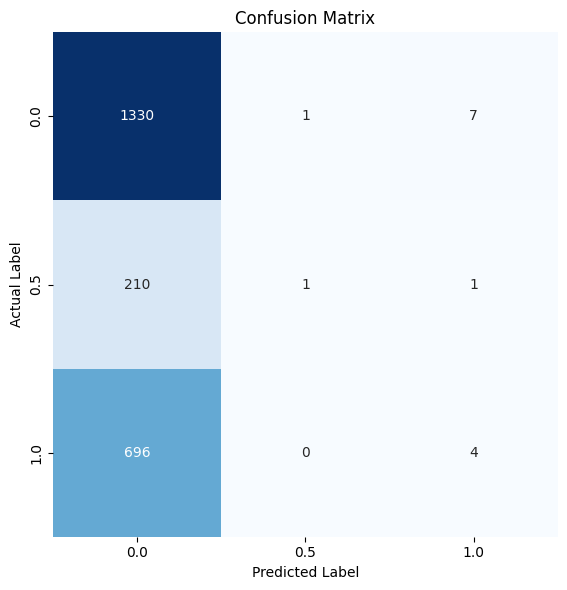

In [ ]:
# Evaluate pruned tree on test set
print("Test Set: ")
y_pred_pruned_test = [predict(pruned_tree, sample) for sample in x_test]
y_pred_pruned_test = np.array(y_pred_pruned_test)
calculate_scores(y_test, y_pred_pruned_test)

print("\nTrain Set: ")
y_pred_pruned_train = [predict(pruned_tree, sample) for sample in x_train]
y_pred_pruned_train = np.array(y_pred_pruned_train)
calculate_scores(y_train, y_pred_pruned_train)

print("\nValidation Set: ")
y_pred_pruned_val = [predict(pruned_tree, sample) for sample in x_val]
y_pred_pruned_val = np.array(y_pred_pruned_val)
calculate_scores(y_val, y_pred_pruned_val)

> Comparing with pre prunning results:

Test Set:
- Accuracy: 0.60
- Precision: 0.44
- Recall: 0.60
- F1 Score: 0.47


Train Set:
- Accuracy: 0.61
- Precision: 0.67
- Recall: 0.61
- F1 Score: 0.47


Validation Set:
- Accuracy: 0.59
- Precision: 0.53
- Recall: 0.59
- F1 Score: 0.45

In [ ]:
# Get rules as a list and all paths
print("All Decision Paths and Rules:")
paths = get_decision_paths(pruned_tree, feature_names=feature_names)
for i, path in enumerate(paths, 1):
  print(f"Path {i}: {path}")

All Decision Paths and Rules:
Path 1: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job <= 0.0 AND Employment Status <= 0.0 THEN class = 0.5
Path 2: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job <= 0.0 AND Employment Status > 0.0 THEN class = 0.0
Path 3: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents <= 0.0 AND Years at Current Job > 0.0 THEN class = 0.0
Path 4: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents > 0.0 AND Number of Dependents <= 0.5 THEN class = 0.0
Path 5: IF Previous Defaults <= 0.0 AND Loan Purpose <= 0.3333333333333333 AND Number of Dependents > 0.0 AND Number of Dependents > 0.5 AND Years at Current Job <= 0.2631578947368421 AND Marital Status <= 0.3333333333333333 AND Employment Status <= 0.0 THEN class = 0
Path 6: IF Previous De